# Bag of Words erstellen

* J.Busse, www.jbusse.de, 2023-04-20, 2023-04-27

Lizenz: public domain / [CC 0](https://creativecommons.org/publicdomain/zero/1.0/deed.de) 

Dateien:
* {download}`regex_XX.zip`
* auspacken; das Verzeichnis `regex_XX/` sollte idealerweise als Geschwister-Verzeichnis des aktuellen Arbeitsverzeichnis `md/` angelegt werden -- oder ggf. Variable `path_to_md` anpassen.

In [1]:
import numpy as np
import pandas as pd

### Global Parameters

In [2]:
# path to files, incl. glob mask
#path_to_md = "md/*.md"
path_to_md = "../regex_XX/*.md"

In [3]:
# show intermediary results
# 0 none, 1 informative, 2 debug
verbosity = 1

def verbose(level,item):
    if level <= verbosity:
        display(item)

Read Files 
----

In [4]:
# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
import glob
files = glob.glob(path_to_md)
verbose(1,f"{len(files)} Dateien gefunden")
# files

'15 Dateien gefunden'

Wir lesen die Daten in das Dictionary `corpus_dict` ein:

In [5]:
def clean_string(string):
    """Liefert string "gesäubert" wieder als String zurück: 
    Interpunktionen, Sonderzeichen etc. 
    werden wie Leerzeichen behandelt."""
    alnum = lambda x: x if x.isalnum() else " "
    return "".join(alnum(c) for c in string )

In [6]:
corpus_dict_of_strings = {}

for file in files:
    with open(file, 'r') as f:
        corpus_dict_of_strings[file] = f.read()
# corpus_dict_of_strings

In [7]:
corpus_dict_of_lists = { doc: clean_string(text).split() 
                        for doc, text in corpus_dict_of_strings.items() }
# corpus_dict_of_lists

In [8]:
doclen = { doc: len(wordlist) for doc, wordlist in corpus_dict_of_lists.items()}
doclen

{'../regex_XX/regex_8.md': 49,
 '../regex_XX/regex_6.md': 29,
 '../regex_XX/regex_5.md': 48,
 '../regex_XX/regex_12.md': 49,
 '../regex_XX/regex_wiki_2.md': 59,
 '../regex_XX/regex_9.md': 62,
 '../regex_XX/regex_2.md': 65,
 '../regex_XX/regex_15.md': 71,
 '../regex_XX/regex_4.md': 45,
 '../regex_XX/regex_wiki_1.md': 64,
 '../regex_XX/regex_14.md': 45,
 '../regex_XX/regex_10.md': 50,
 '../regex_XX/regex_7.md': 52,
 '../regex_XX/regex_1.md': 49,
 '../regex_XX/regex_13.md': 26}

`all_words_set`: Alle Wörter, die im "gesäuberten" Korpus vorkommen

In [9]:
all_words_set = { w for d in corpus_dict_of_lists.values() for w in set(d) }
" ".join(sorted(list(all_words_set)))[:80]
len(all_words_set)

310

`all_words_dict`: Ein Dictionary, in dem wir zählen, wie häufig ein Wort insgesamt im Korpus vorkommt. Um später Speicherplatz und Laufzeit zu sparen, gehen wir den Korpus einmal komplett durch und zählen.

In [10]:
# Initialisierung: dict anlegen und für jedes Wort auf die Häufigkeit 0 setzen
all_words_count = { k: 0 for k in all_words_set}

for text in corpus_dict_of_lists.values():
    for word in text:
        all_words_count[word] += 1
# all_words_count

Für die Textähnlichkeit interessieren nur Wörter, die nicht nur in einem einzigen Dokument vorkommen. ... Und wir filtern auch gleich bedeutungslose Wörter heraus.

In [11]:
# Quelle: https://www.ranks.nl/stopwords/german
stoppwoerter = """aber als am an auch auf aus bei bin bis bist 
da dadurch daher darum das daß dass dein deine dem den der des 
dessen deshalb die dies dieser dieses doch dort du durch ein 
eine einem einen einer eines er es euer eure für hatte hatten 
hattest hattet hier hinter ich ihr ihre im in ist ja jede jedem 
jeden jeder jedes jener jenes jetzt kann kannst können könnt 
machen mein meine mit muß mußt musst müssen müßt nach nachdem 
nein nicht nun oder seid sein seine sich sie sind soll sollen 
sollst sollt sonst soweit sowie und unser unsere unter vom von 
vor wann warum was weiter weitere wenn wer werde werden werdet 
weshalb wie wieder wieso wir wird wirst wo woher wohin zu 
zum zur über""".split()

len(stoppwoerter)

129

In [12]:
early_word_elimination = True
if early_word_elimination:
    all_words_count_nosingles = { word: count for word, count in all_words_count.items() 
                                 if count > 1 and not word.lower() in stoppwoerter }
else:
    all_words_count_nosingles  = all_words_count
# print(all_words_count_nosingles)
len(all_words_count_nosingles)

113

Welche Wörter haben wir verworfen, weil sie nur einmal vorkommen oder Stoppwörter sind? Wie viele sind das?

In [13]:
verworfen = set(all_words_count) - set(all_words_count_nosingles)
# print(nureinmal)
# verworfen

`document_word_count`: Ein Dictionary von Dictionaries: Für jedes Dokument zählen wir für jedes Wort in dem Dokument, wie häufig das Wort im Dokument vorkommt.

In [14]:
document_word_count = {}

verbosity = 1

# gehe durch unseren Korpus durch
for doc, text in corpus_dict_of_lists.items():
    
    verbose(2, text) # debug
    
    # Initialisiere für das aktuelle Dokument ein neues, leeres Dictionary
    # word count absolut
    document_word_count[doc] = dict.fromkeys(all_words_count_nosingles, 0)
    
    # für jedes Wort im aktuellen Dokument
    for word in text:
        
        # kommt das aktuelle Wort öfters als nur einmal im Korpus vor?
        if word in all_words_count_nosingles:
            document_word_count[doc][word] += 1

# document_word_count

In [15]:
# total_word_count_from_document_word_count
twcfdwc  = dict.fromkeys(all_words_count_nosingles, 0)

for doc, text in corpus_dict_of_lists.items():
    for word in text:
        if word in twcfdwc:
            twcfdwc[word] += 1
# twcfdwc

In [16]:
if not early_word_elimination:
    twcfdwc_nosingles = { word: count for word, count in twcfdwc.items() 
                                 if count > 1 and not word.lower() in stoppwoerter }
else:
    twcfdwc_nosingles = twcfdwc
twcfdwc_nosingles

{'prüfen': 2,
 'Ausdruck': 6,
 'Anwendung': 2,
 'Dafür': 2,
 'beliebiges': 2,
 'Suche': 2,
 'Zeichens': 2,
 'expression': 3,
 'gültige': 2,
 'mindestens': 2,
 'kompakter': 2,
 'Regulatität': 2,
 'regex': 2,
 'dabei': 4,
 'dafür': 2,
 'Automat': 4,
 'man': 10,
 'vorangehenden': 2,
 'beliebig': 3,
 'benutzt': 2,
 'dar': 2,
 'sehr': 2,
 'Character': 2,
 'formalen': 2,
 'teil': 2,
 'Informatik': 3,
 'mittels': 2,
 'endlichen': 4,
 'durchsuchen': 3,
 'bzw': 2,
 'A': 2,
 'Regex': 13,
 'lassen': 2,
 'Vielzahl': 2,
 'viele': 3,
 'Mustern': 2,
 'umgekehrt': 2,
 'um': 6,
 'Text': 6,
 'verschiedenen': 2,
 'ohne': 2,
 'Ausdrucks': 5,
 'repräsentieren': 2,
 'Alle': 2,
 'Zeichen': 7,
 'suchen': 3,
 'Sprachen': 2,
 'möglich': 3,
 'Ausdrücke': 13,
 'allem': 4,
 'regular': 3,
 'Punkt': 2,
 'gefunden': 2,
 'Klassen': 2,
 'elixir': 2,
 'Sprache': 6,
 'foo': 4,
 'beliebige': 4,
 'Symbolen': 2,
 'Ausdrücken': 3,
 'Operators': 2,
 'Gruppen': 2,
 'Muster': 2,
 'häufige': 2,
 '0': 2,
 'stellen': 2,
 'Suchkrit

## Exkurs:  des Winkels zwischen zwei Vektoren

https://www.gut-erklaert.de/mathematik/skalarprodukt-winkel-vektoren-formel.html

In [17]:
import numpy as np

In [18]:
a = np.array((1, 2, 3))
b = np.array((4, 5, 6))

In [19]:
np.dot(a, b)

32

In [20]:
cos_alpha = np.dot(a, b) / ( np.dot(a,a)**.5 * np.dot(b,b)**.5 )
cos_alpha

0.9746318461970762

## Cosinus zwischen zwei unserer Texte

Nochmal zur Erinnerung: die Liste `files` enthält die Dateinamen unseres Korpus:

In [21]:
files[0]

'../regex_XX/regex_8.md'

Also können wir so auf die Wörterzählungen der ersten Datei zugreifen, wenn wir den Dateinamen nicht tippen wollen:

In [22]:
print(list(document_word_count[files[0]].values()))

[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
a = np.array(list(document_word_count['../regex_XX/regex_8.md'].values())) # erste Datei, hier '../regex_XX/regex_8.md'
b = np.array(list(document_word_count[files[1]].values())) # zweite Datei, hier '../regex_XX/regex_6.md'

In [24]:
cos_alpha = np.dot(a, b) / ( np.dot(a,a)**.5 * np.dot(b,b)**.5 )
cos_alpha

0.1072112534837795

## Matrix erstellen

"Zu Fuß", noch im Lernprozess: Wir müssen unser dict `document_word_count` in eine "Matrix" umwandeln, hier zunächst eine Liste von Listen.

In [25]:
matrix = [ list(document_word_count[f].values()) for f in files ]
print(matrix)

[[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Um Bibliotheken effizient nutzen zu können, benötigen wir diese Matrix in einer speichereffizienten Form. Üblierweise macht man das mit Numpy: <https://numpy.org/doc/stable/user/absolute_beginners.html>

In [26]:
matrix_np = np.array(matrix)
matrix_np

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(matrix_np)

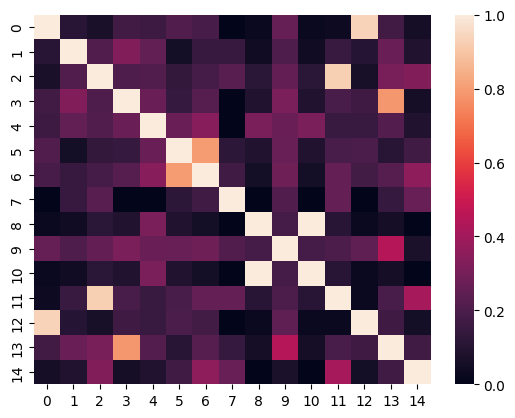

In [28]:
import seaborn as sns
mask = np.zeros_like(similarity)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(similarity)

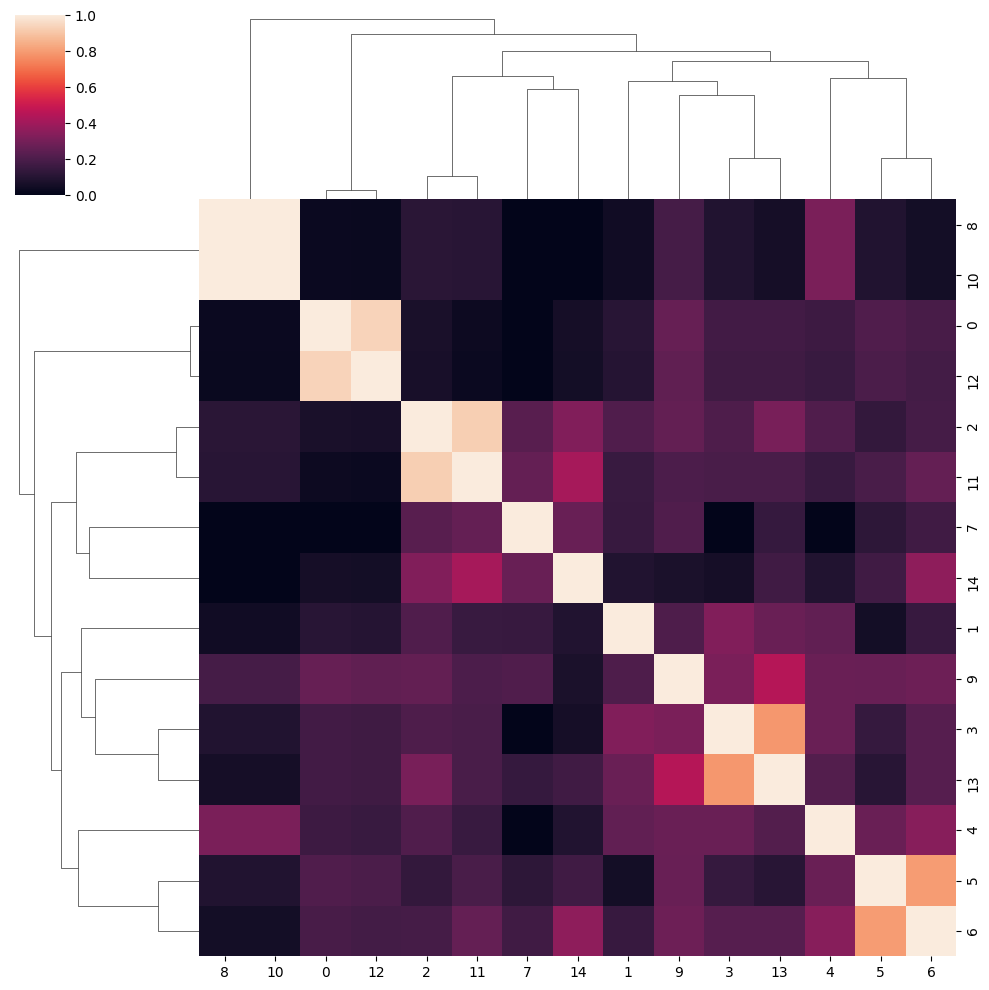

In [29]:
ax = sns.clustermap(similarity)
# ax.savefig("clustermap.png")

In [30]:
files[3]

'../regex_XX/regex_12.md'